# 11-9. 프로젝트 : 주식 예측에 도전해 보자
ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해보자! -> 삼성전자

## STEP 1 : 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장됨
- 종가(close)만 사용하자..

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings # warning ignore
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


시간 컬럼을 index로 하는 series 데이터. pandas를 통해 7개의 컬럼을 가진 dataframe으로 변환되었다. 

위의 dataframe에서 date컬럼을 인덱스로 삼는 시계열 데이터를 생성해보자

In [2]:
# date -> index_col로 지정
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
ts1 = df['Close'] # 데이터 확인용으로 time series 이니셜인 ts로 명명, 종가인 'Close'만 가져온다
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

데이터 프레임인 df와 series인 df['Close'] 는 index구조가 동일하므로 넘파이, 판다스, matplotlib등 많은 라이브러리들이 호환해서 지원함

간혹 안되는 경우가 있어서 여기서는 series객체를 가지고 진행해보자

## STEP 2 : 각종 전처리 수행
- 결측치 처리
- 로그 변환

### 2-1 결측치 처리

In [4]:
# 결측치 확인(있는 부분만 series로 출력)
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

결측치가 없음... 만약에 결측치가 있으면?

1. 결측치가 있는 데이터를 모두 삭제(drop)
2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)해서 대입 ex) 2와 4사이 데이터가 nan이라면 이 값을 3으로 채운다

이번 경우에는 시간을 index로 가지는 시계열 데이터라서 2번 선택!

Series([], Name: Close, dtype: float64)


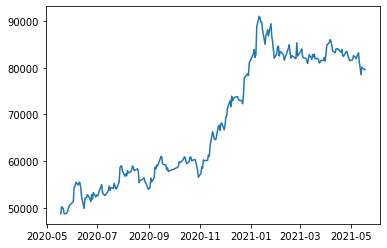

In [5]:
# 결측치가 있을경우, 보간하는 방법 : 보간 기준은 time 선택
ts1 = ts1.interpolate(method='time')

# 보간 이후 결측치 유무 확인
print(ts1[ts1.isna()])

# 그래프로 확인
plt.plot(ts1)

### 2-1 로그 변환

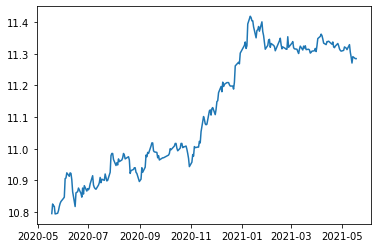

In [6]:
ts_log = np.log(ts1)
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 3-1 정성적 그래프 분석

#### 시계열 안정성의 정성적 분석
:시각화를 통해 안정성(stationarity)여부를 확인해보자

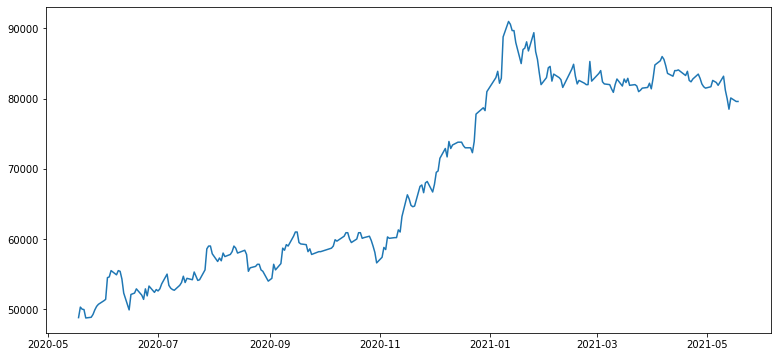

In [7]:
def plot_rolling_statistics(timeseries, window=9):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화한다
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 # matlab차트의 기본 크기 13,6으로 지정

# 시계열 데이터를 차트로
plt.plot(ts1)

시간 추이에 따라 일정하게 평균, 분산, 자기공분산 패턴이 나타난다, 통계적 특성을 명료하게 시각화해보자

일정시간 내 구간 통계치(rolling statistics)를 시각화해보는 함수 현재 타임 스텝부터 window에 주어진 타임 스텝 이전 사이

1. 구간의 평균(rolling mean, 이동평균)
2. 표준편차(rolling std, 이동표준편차) 를 원본 시계열과 함께 시각화해서 뚜렷한 경향성을 확인해볼수 있다

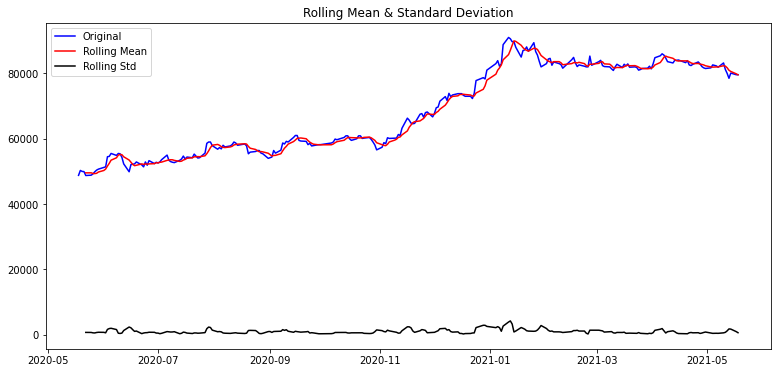

In [8]:
def plot_rolling_statistics(timeseries, window=9):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차 시계열
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화한다
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts1, window=5)

### 3-2 정량적 Augmented Dickey-Fuller Test
: 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법

주어진 시계열 데이터가 안정적이지 않다는 귀무가설을 세운다
통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우
이 시계열 데이터가 안정적이다는 대립가설(alternative hypothesis)을 채택한다
귀무가설이란?

통계학에서 처음부터 버릴 것을 예상하는 가설, 차이가 없거나 의미있는 차이가 없는 경우의 가설이며 이것이 맞거나 맞지 않다는 통계학적 증거를 통해 증명하려고 한다 ~와 차이가 없다, ~의 효과가 없다와 같은 형식으로 설정된다

대립가설이란?

귀무가설이 거짓일 경우 대안적으로 참이 되는 가설, ~와 차이가 있다, ~의 효과는 있다, ~와 다르다 등등으로 설정

p-value의 정의는 귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치가 나타날 확률, p값이 낮다는 것은 귀무가설이 참이라는 가정 하에서 표본을 추출했을 때, 이런 표본 평균이 관측될 확률이 낮다는 것을 뜻한다. 즉 p값이 매우 낮으면, 이러한 표본 통계량은 우연히 나타나기 어려운 케이스이기 때문에, 우리는 대립가설을 선택한다

#### statsmodels 패키지와 adfuller 메서드
statsmodels 패키지 = R에서 제공하는 통계검정, 시계열분석 등의 기능을 파이썬에서도 이용할 수 있도록 함

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 Augmented Dickey-Fuller Test를 수행해보자!

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 0.66수준이므로 1에 더 가깝기 때문에 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적이라고 말할 수 없다.

#### 보다 stationary하게 가공하자

#### 1. Moving average 제거(추세 Trend 상쇄하기)

시계열 분석에서 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다. 이 변화량을 제거해 주려면 거꾸로 moving average, 즉 rolling mean을 구해서 ts_log에서 빼주면 된다.

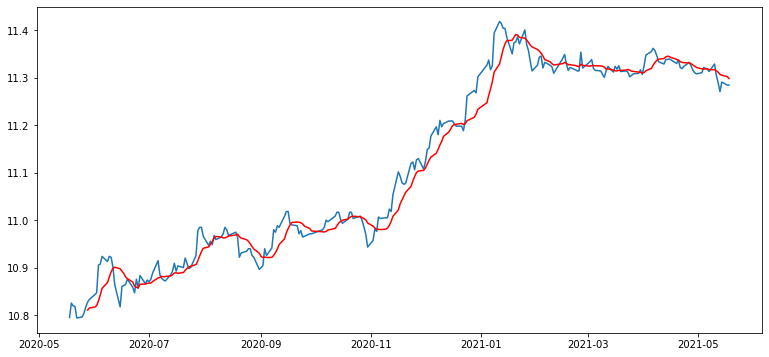

In [10]:
moving_avg = ts_log.rolling(window=9).mean()  # moving average구하기 , 근데 왜 window=12지?
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [11]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(40)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28    0.016529
2020-05-29    0.018220
2020-06-01    0.026063
2020-06-02    0.026893
2020-06-03    0.075769
2020-06-04    0.065010
2020-06-05    0.067178
2020-06-08    0.044241
2020-06-09    0.043293
2020-06-10    0.030980
2020-06-11    0.003303
2020-06-12   -0.036587
2020-06-15   -0.080272
2020-06-16   -0.032124
2020-06-17   -0.025212
2020-06-18   -0.016699
2020-06-19   -0.001169
2020-06-22   -0.011091
2020-06-23   -0.014370
2020-06-24    0.017298
2020-06-25   -0.000934
2020-06-26    0.018360
2020-06-29    0.000692
2020-06-30    0.007027
2020-07-01    0.002596
2020-07-02    0.008284
2020-07-03    0.018062
2020-07-06    0.036325
2020-07-07    0.005757
2020-07-08   -0.004092
2020-07-09   -0.006826
2020-07-10   -0.009356
Name: Close, dtype: float64

문제는 moving average계산 시 (windows size=9인 경우), 앞의 8개 데이터는 moving average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)이 발생한다는 것임

향후 Dicky-Fuller Test시에 에러를 발생시킬 것이므로 데이터셋에서 제거

In [12]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-05-28    0.016529
2020-05-29    0.018220
2020-06-01    0.026063
2020-06-02    0.026893
2020-06-03    0.075769
2020-06-04    0.065010
2020-06-05    0.067178
2020-06-08    0.044241
2020-06-09    0.043293
2020-06-10    0.030980
2020-06-11    0.003303
2020-06-12   -0.036587
2020-06-15   -0.080272
2020-06-16   -0.032124
2020-06-17   -0.025212
Name: Close, dtype: float64

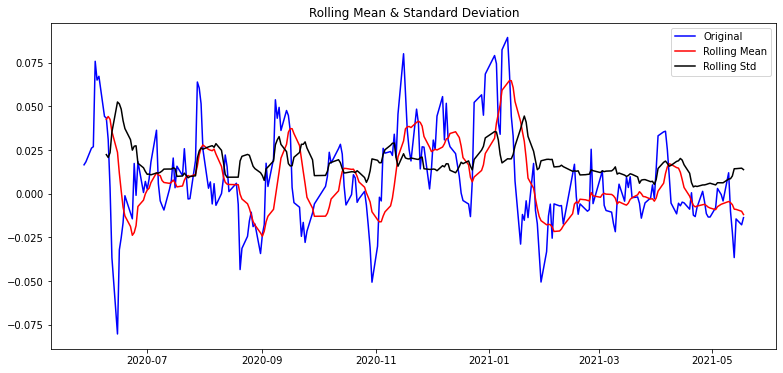

In [13]:
plot_rolling_statistics(ts_log_moving_avg) # 정성적 분석

In [14]:
augmented_dickey_fuller_test(ts_log_moving_avg) # 정량적 분석

Results of Dickey-Fuller Test:
Test Statistic                  -4.906168
p-value                          0.000034
#Lags Used                       0.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


p-value가 0.000034수준으로 낮아짐. 95%이상의 confidence로 이 시계열은 stationary하다고 할 수 있다.

만약에 moving average를 계산하는 window를 내가 지정한 9말고 다른 값으로 지정하면 어떻게 될까?

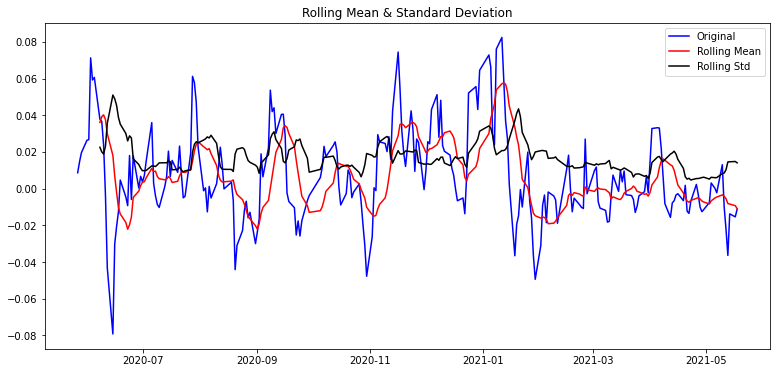

In [15]:
moving_avg_8 = ts_log.rolling(window=8).mean()
ts_log_moving_avg_8 = ts_log - moving_avg_8
ts_log_moving_avg_8.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_8)

In [16]:
augmented_dickey_fuller_test(ts_log_moving_avg_8)

Results of Dickey-Fuller Test:
Test Statistic                  -5.589878
p-value                          0.000001
#Lags Used                       1.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


5~12까지의 값을 window에 대입해본 결과, 가장 낮은 p-value값을 내는 것은 8이었다. 0.000001로 나왔고, 다른 값들은 그것보다 꽤 큰 값으로 나왔음! 8일을 단위로 주기성을 가진다는 결론을 내렸다. moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억하자!

이제 시간의 추이에 따라 평균이 증가하는 trend를 제거했다. 

#### 2. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소다. moving average제거로는 상쇄되지 않는다. 이런 계절적, 주기적 패턴을 계절성(seasonality)이라고 한다.

패턴을 상쇄하기 위해 효과적인 방법으로는 차분(differencing)이 있다. 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다. 이렇게 되면 남은 것은 현재 스텝 값-직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미한다.

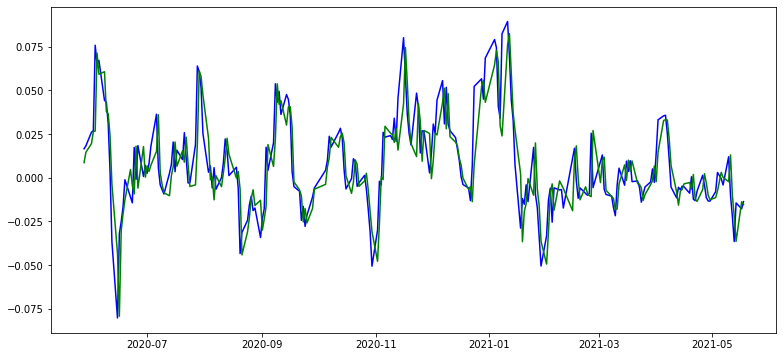

In [17]:
# 시프트한 시계열과 원본 시계열 그래프
ts_log_moving_avg_shift = ts_log_moving_avg_8.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

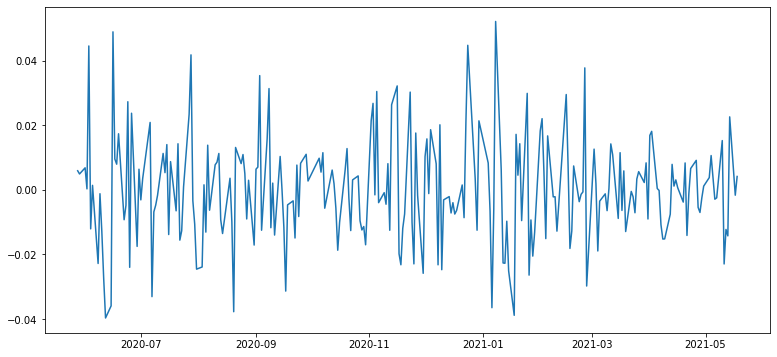

In [18]:
# 원본 시계열 - 시프트한 시계열
ts_log_moving_avg_diff = ts_log_moving_avg_8 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해보자

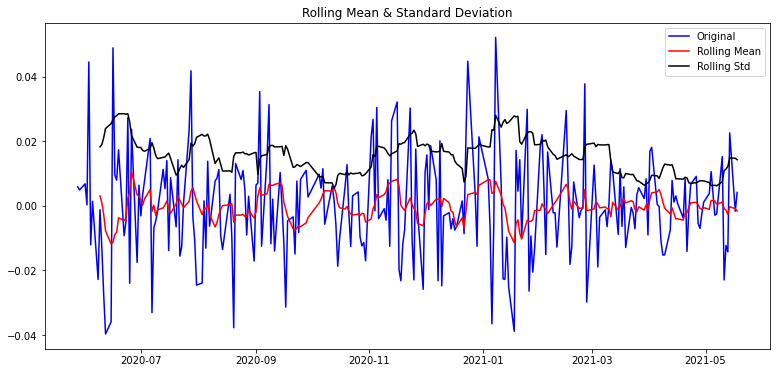

In [19]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [20]:
# 차분의 효과는?
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.198687e+00
p-value                        2.396952e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


이동평균을 빼서 추세를 제거하고 난 시계열에 1차 차분을 적용해서 seasonality효과를 상쇄한 결과, p-value값이 꽤나 낮아진 것을 확인할 수 있다....

### 3-3 시계열 분해(Time Series Decomposition)
statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다. 이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있음

이번에는 위에서 구했던 로그 변환 단계(ts_log)에서부터 해보자

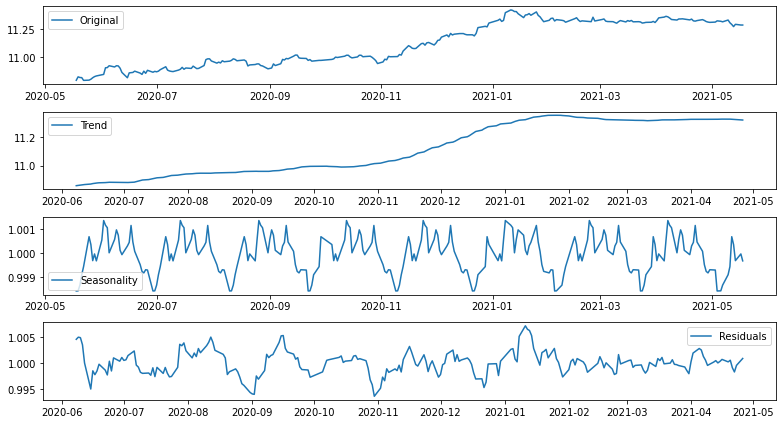

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3-4 Residual 안정성 확인
: Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻. 이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시한다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져보자


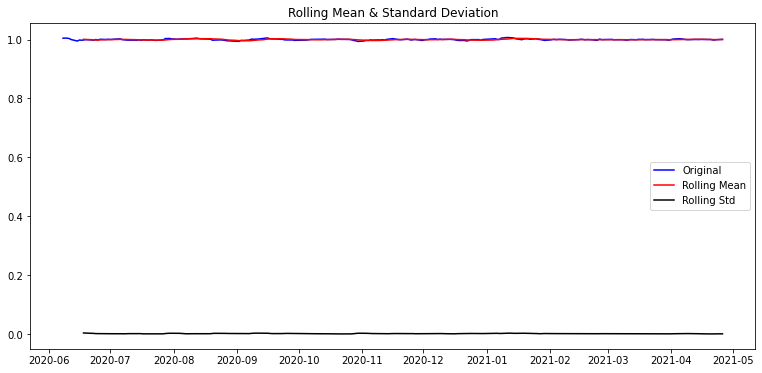

In [22]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [23]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


아까 trend와 seasonality를 제거했을 때보다는 높지만, 간단하게 시도한 것 치고는 굉장히 낮은 결과를 얻을 수 있다. 바로 Time Series Decomposing을 사용하는게 가성비가 좋을 것 같다 !

## STEP 4 : 학습, 테스트 데이터셋 생성

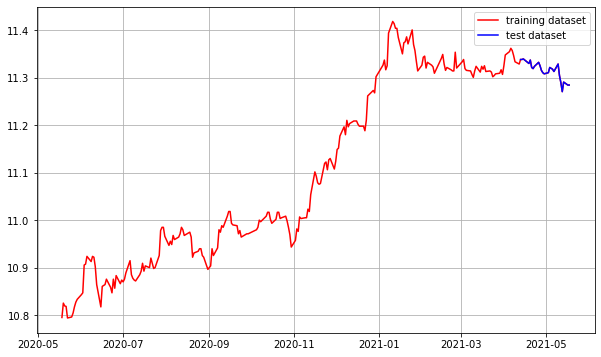

In [24]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):] # 9:1
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [25]:
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## STEP 5 : 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

#### ARIMA 모델의 개념

앞에서 시계열 데이터가 Trend와 Seasonality, Residual로 분해되는 것을 확인했다. 또, Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인했다.

ARIMA(Autoregressive Integrated Moving Average)를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있다.

ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average) 라고 할 수 있다.
1. AR(자기회귀, Autoregressive) : 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
2. MA(이동평균, Moving Average) : 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점
3. I(차분 누적, Integration) : Y t​이 이전 데이터와 dd차 차분의 누적(integration) 합이라고 보는 모델

ARIMA는 위 3가지 모델을 모두 한꺼번에 고려함

- '오늘은 주식이 올라서 균형을 맞추겠지?'라는 AR 형태의 기대와
- '어제 떨어졌으니 추세적으로 계속 떨어지지 않을까?'라는 MA 형태의 우려

사이에서 ARIMA는 두 모델 사이에서 적정 수준을 찾아간다


#### ARIMA 모델의 모수 p, q, d
: ARIMA의 모수 (parameter)를 잘 설정해야 한다

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

### 5-1 ACF, PACF 그려보기 -> p,q 구하기

International airline passengers 시계열을 이용해서 statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용해보자!

- ACF = 시차에 따른 관측치들 사이의 관련성을 측정하는 함수, x축(상관계수), y축(시차수)
- PACF = 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

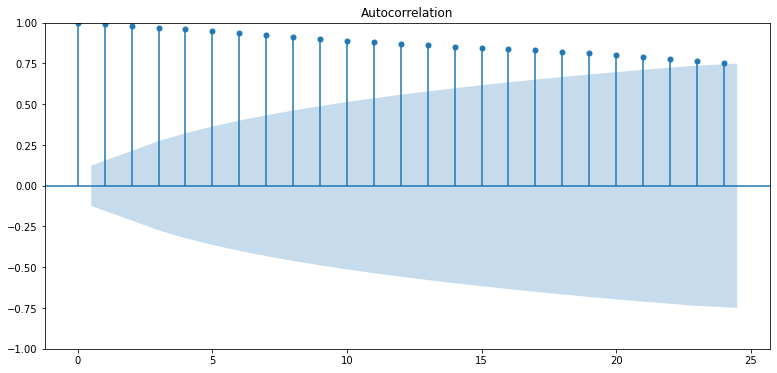

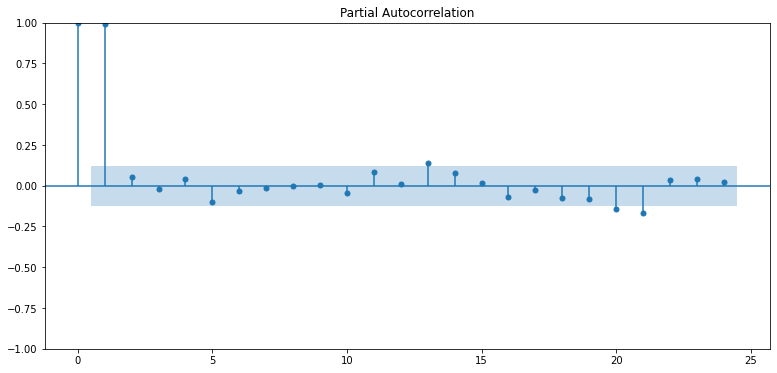

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

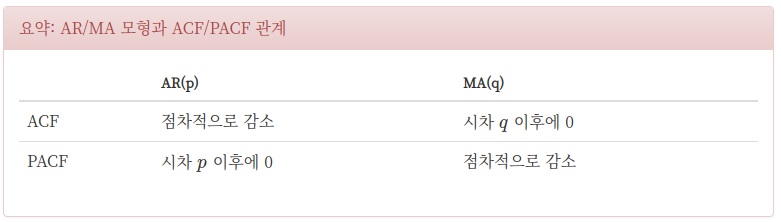

p = 1이 적합하다. pacf 그래프를 볼때 p가 2 이상인 구간에서 거의 0에 가까워지고 있음 그 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0 이라는 뜻이라서 고려할 필요가 없다..

반면 ACF는 점차 감소하고 있기 때문에 AR(1)모델에 유사한 형태를 보인다. q에 대해서는 적합한 값이 없어 보임 MA를 고려할 필요가 없으면 q=0으로 둬도 된다. 하지만 바꿔가면서 찾아도 된다. 

하지만 실제로 아래 모델에서 여러 모수를 대입해본 결과, 여기서는 p =2, q =1로 주기로 했다.

### 5-2 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


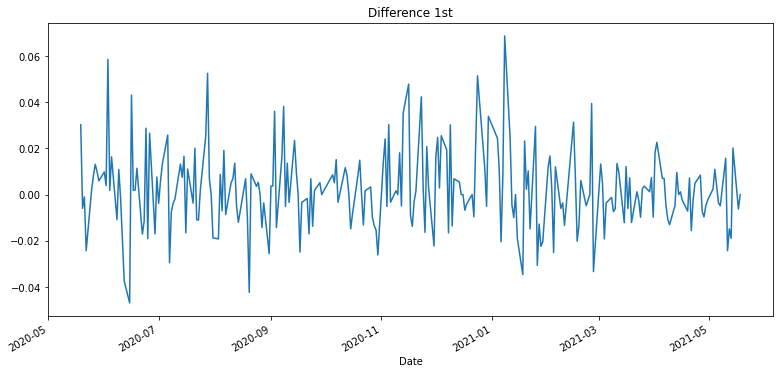

In [27]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [28]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data, seasonal=False, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1159.385, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.527 seconds


자동으로 모수를 찾아주는 auto_arima를 사용해봤지만 딱히 mape점수가 낮아지진 않았다 .. 오히려 차분은 0으로 두는 것이 가장 점수가 낮았다.. 이유에 대해서는 아직 잘 모르겠다.

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

### 6-1 ARIMA 모델 빌드와 훈련

In [29]:
# ARIMA 모델을 훈련

import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1)) # 모수는 여러 값을 대입해보았음
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Mon, 14 Feb 2022   AIC                          -1156.722
Time:                        07:00:02   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).

이라는 오류가 뜨지만 첫 번째는 실제로 "경고"보다 "참고"에 가깝다. 공분산 행렬이 어떻게 계산되었는지 알려주는 것이다.

### 6-2 모델 테스트 및 플로팅


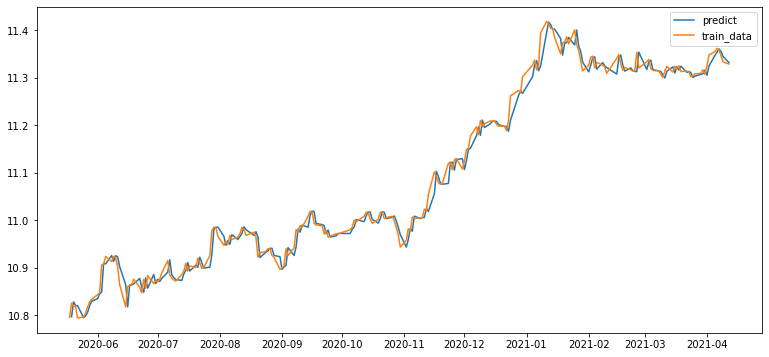

In [30]:
# ARIMA 모델이 훈련 결과를 시각적으로 확인

fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

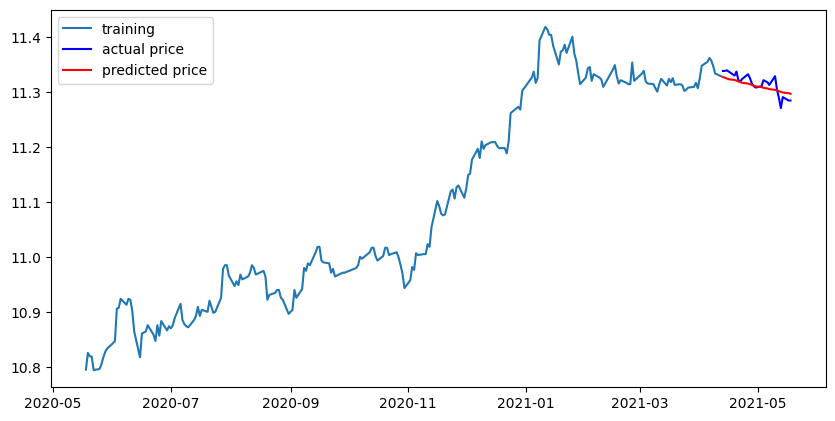

In [31]:
# Forecast : 결과가 fc에 담김
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 6-3 최종 예측 모델 정확도 측정(MAPE)

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다

np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산한당

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


여러 값을 대입해본 결과 ARIAM모수 2, 0, 1에서 MAPE = 1.03으로 가장 낮았다.

## STEP 7 : 다른 주식 종목 예측해 보기
- 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

## AAPL 

### 1. 데이터 준비 및 전처리

In [33]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath)

# date -> index_col로 지정
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df['Close'] # 데이터 확인용으로 time series 이니셜인 ts로 명명, 종가인 'Close'만 가져온다
print(type(ts2))
ts2.head()

<class 'pandas.core.series.Series'>


Date
2021-02-11    135.130005
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


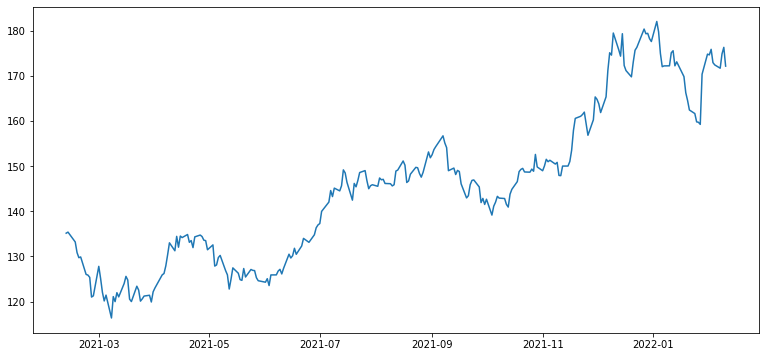

In [34]:
# 결측치가 있을경우, 보간하는 방법 : 보간 기준은 time 선택
ts = ts2.interpolate(method='time')

# 보간 이후 결측치 유무 확인
print(ts2[ts2.isna()])

# 그래프로 확인
plt.plot(ts2)

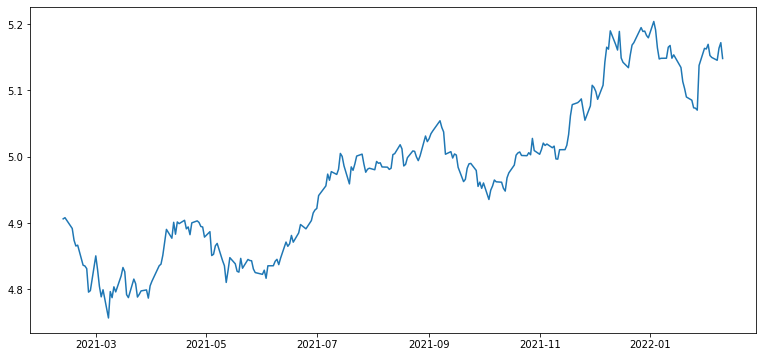

In [35]:
# 로그 변환
ts_log = np.log(ts2)
plt.plot(ts_log)

### 2. 시계열 안정성 분석

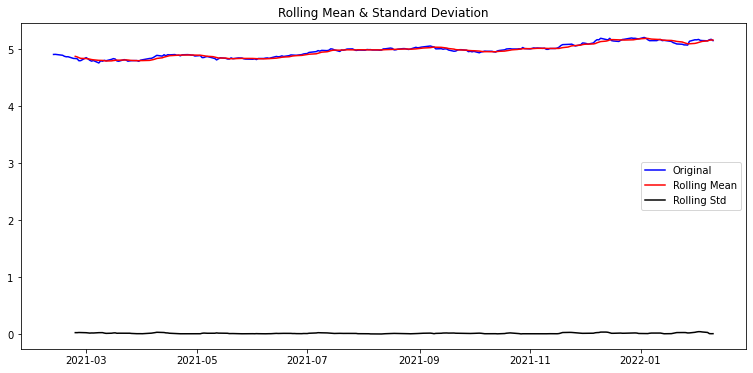

Results of Dickey-Fuller Test:
Test Statistic                  -0.587076
p-value                          0.873876
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


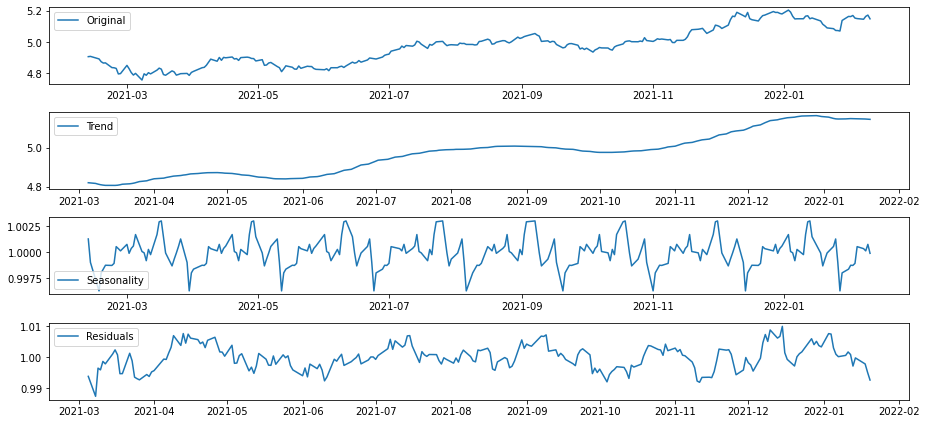

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=8)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.215658
p-value                          0.000008
#Lags Used                       0.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


### 3. 학습, 테스트 데이터셋 생성

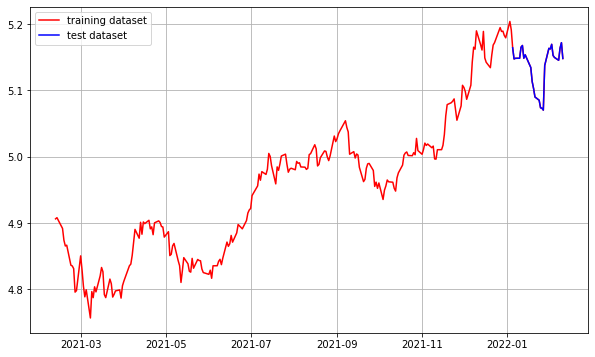

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 4. 적정 ARIMA 모수 찾기

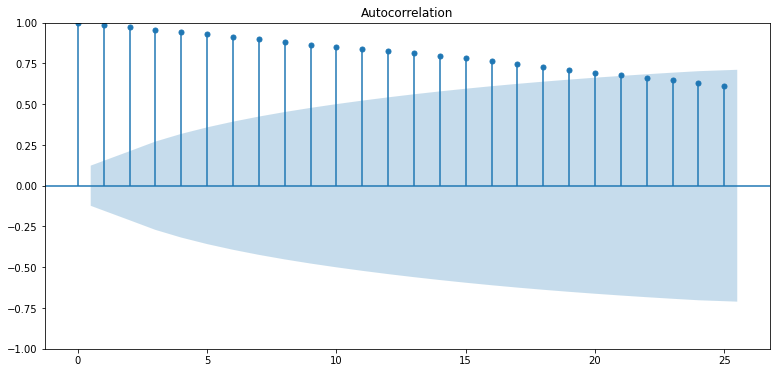

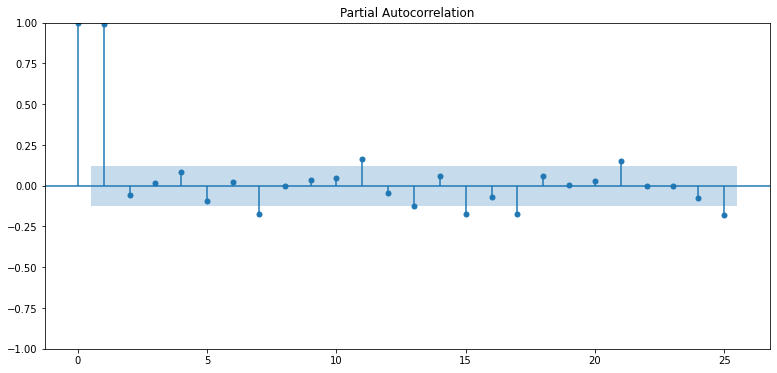

In [39]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.600682e+01
p-value                        6.420431e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


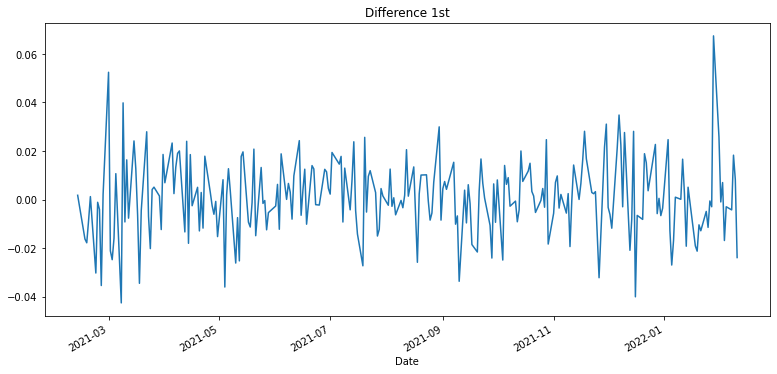

In [40]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5. ARIMA 모델 훈련과 테스트

In [41]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 627.469
Date:                Mon, 14 Feb 2022   AIC                          -1242.938
Time:                        07:00:06   BIC                          -1222.388
Sample:                             0   HQIC                         -1234.646
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8811      0.280     17.433      0.000       4.332       5.430
ar.L1          0.0761      0.227      0.335      0.738      -0.369       0.521
ar.L2          0.9168      0.226      4.055      0.0

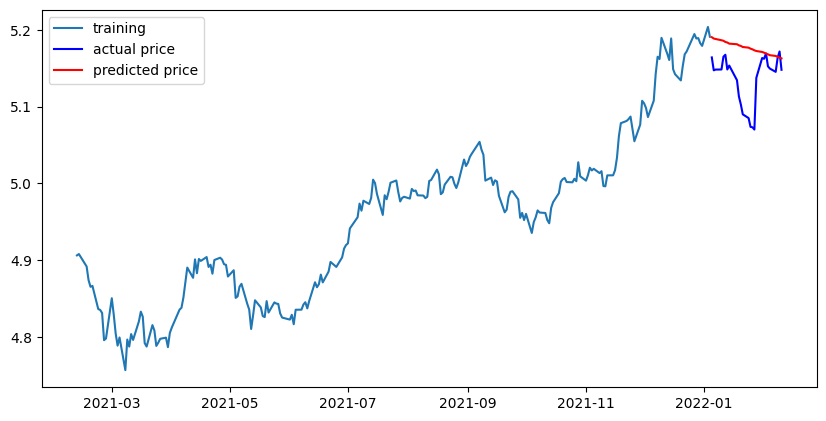

In [42]:
# Forecast : 결과가 fc에 담긴다
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  78.85470426210028
MAE:  6.943737256555793
RMSE:  8.88001713185849
MAPE: 4.19%


여러 값을 대입해 본 결과 ARIMA모수 2, 0, 2에서 mape = 4.19%로 가장 낮은 점수를 보였다.

## TSLA

### 1. 데이터 준비 및 전처리

In [44]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath)

# date -> index_col로 지정
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts3 = df['Close'] # 데이터 확인용으로 time series 이니셜인 ts로 명명, 종가인 'Close'만 가져온다
print(type(ts3))
ts3.head()

<class 'pandas.core.series.Series'>


Date
2021-02-11    811.659973
2021-02-12    816.119995
2021-02-16    796.219971
2021-02-17    798.150024
2021-02-18    787.380005
Name: Close, dtype: float64

Series([], Name: Close, dtype: float64)


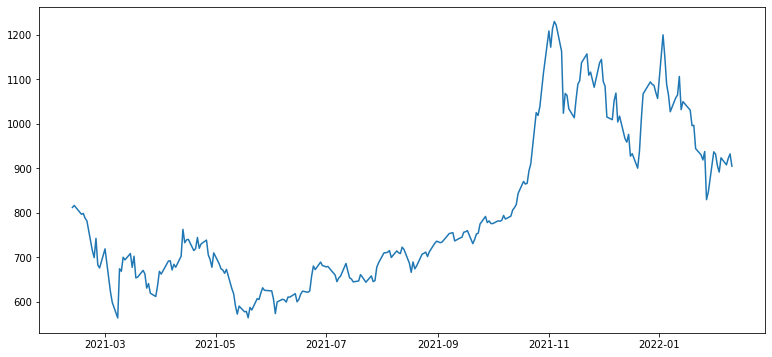

In [45]:
# 결측치가 있을경우, 보간하는 방법 : 보간 기준은 time 선택
ts = ts3.interpolate(method='time')

# 보간 이후 결측치 유무 확인
print(ts3[ts3.isna()])

# 그래프로 확인
plt.plot(ts3)

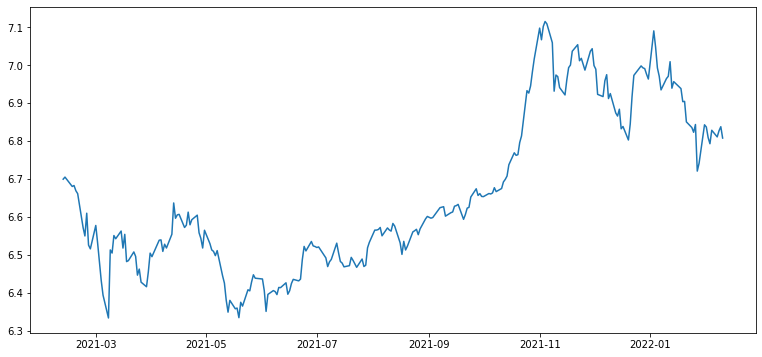

In [46]:
# 로그 변환
ts_log = np.log(ts3)
plt.plot(ts_log)

### 2. 시계열 안정성 분석

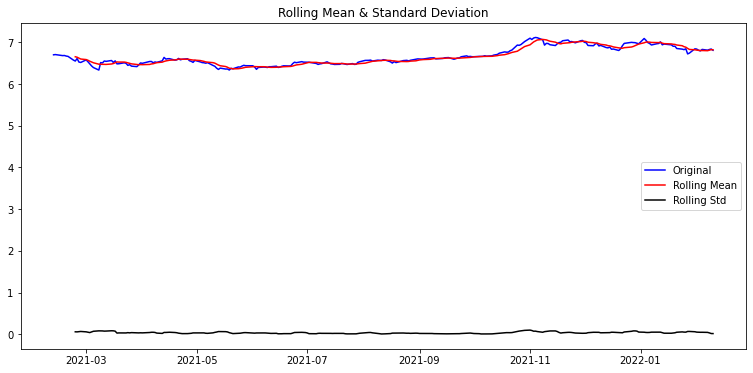

Results of Dickey-Fuller Test:
Test Statistic                  -1.274102
p-value                          0.640936
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


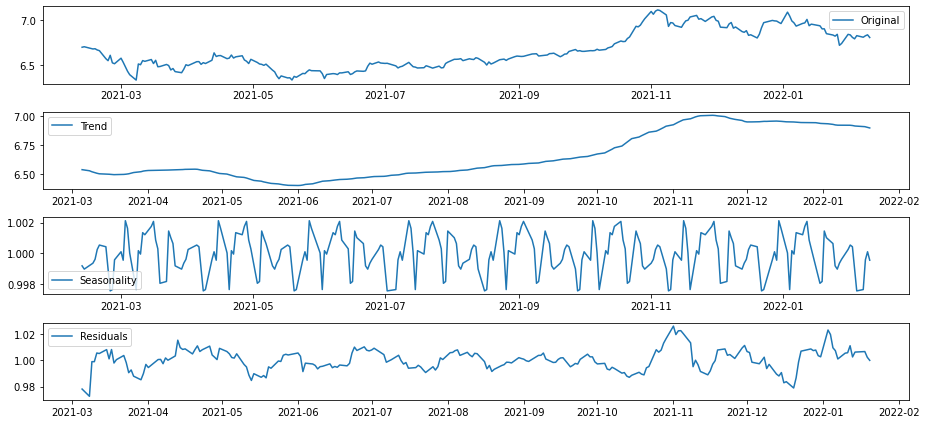

In [47]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=8)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.135278e+00
p-value                        8.215607e-08
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


### 3. 학습, 테스트 데이터셋 생성

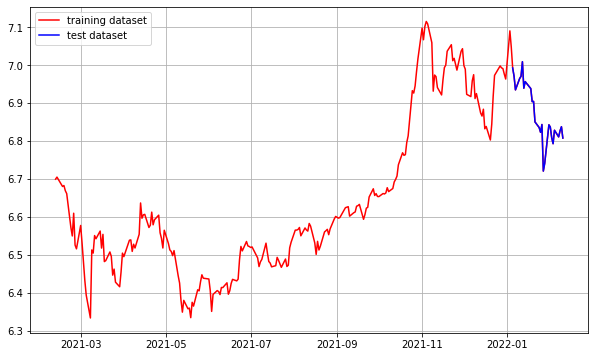

In [49]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 4. 적정 ARIMA 모수 찾기 

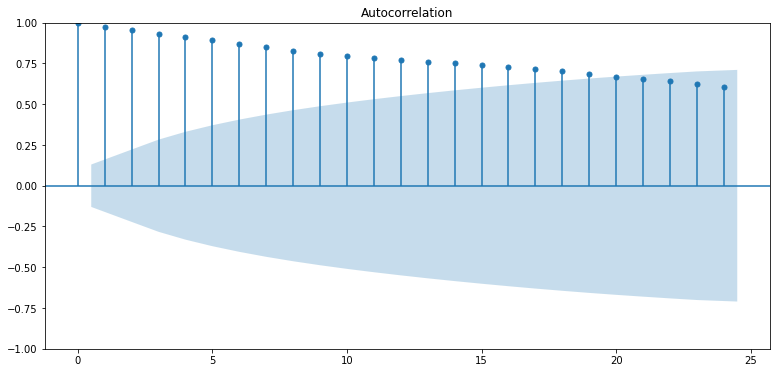

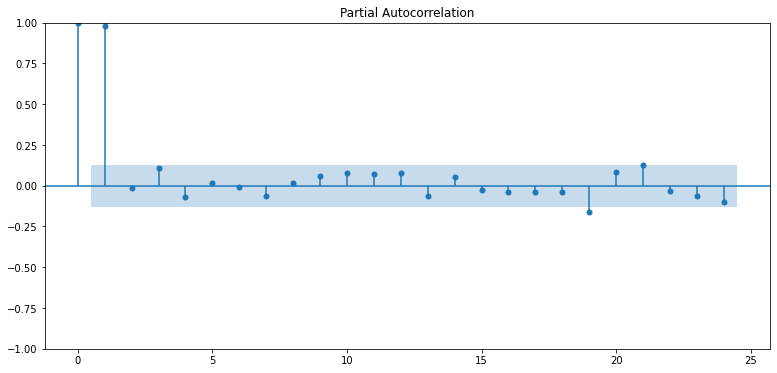

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_data)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(train_data)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.688327e+01
p-value                        1.058847e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


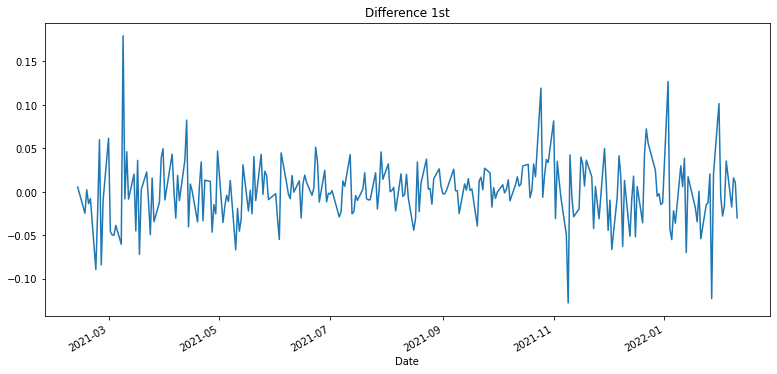

In [51]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 5. ARIMA 모델 훈련과 테스트

In [52]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 3))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 439.902
Date:                Mon, 14 Feb 2022   AIC                           -865.803
Time:                        07:00:09   BIC                           -841.829
Sample:                             0   HQIC                          -856.129
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7250      0.195     34.479      0.000       6.343       7.107
ar.L1          0.2821      1.121      0.252      0.801      -1.915       2.479
ar.L2          0.6963      1.111      0.627      0.5

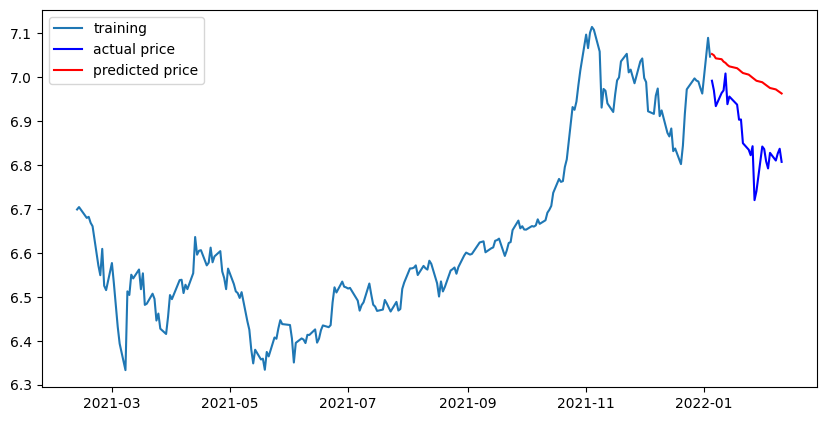

In [53]:
# Forecast : 결과가 fc에 담긴다
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20987.395579820884
MAE:  135.16315272254332
RMSE:  144.87027155293416
MAPE: 14.44%


여러 값을 대입해 본 결과 ARIMA모수 2, 0, 3에서 14.44%라는 가장 낮은 mape 점수를 보였다. 아직까지 p, q, d에 대한 정확한 이해를 못해서 그래프를 보고 값을 결정하지 못한 점이 아쉬움으로 남는다. Acf, Pacf와 차분에 대한 더 깊은 이해가 필요할 것 같다.